## David Miranda & Heather Lemon 
### COMP 4448 Tools 2 Final Project Steam 

Dataset Location: 
https://www.kaggle.com/datasets/deepann/80000-steam-games-dataset 


**Steam** is a widely popular video game distribution platform. Currently there are over 50,000 different games 
available for purchase. It was launched as a software client in September 2003 as a way for Valve to provide automatic updates for their games, and expanded to distributing and offering third-party game publishers' titles in late 2005. [0] Steam sales data is not publicly availble, but we can use the number of reviews
as a good estimate for units sold this is called the Boxleiter or New Boxleiter number method, estimating the number of Steam game unit sold based on the number of reviews they got. [1][2]

One very important aspect to keep in mind is the time and price that this data was collected which was two years ago. The metrics and analysis we will perform are from data collected two years ago and will be different that what maybe be currently presented in Steam today. Games could have been removed, sales could have been happening that are no longer available, or the game could be free now. 

[0] https://en.wikipedia.org/wiki/Steam_(service) 

[1] https://vginsights.com/insights/article/how-to-estimate-steam-video-game-sales 

[2] https://newsletter.gamediscover.co/p/how-that-game-sold-on-steam-using


#### Research Question
Indie game developer Liquid Courage Studios wants to publish a new game called Ace Vendetta and wants to know how much to sell their game for? 

![steam](steam.png)

In [877]:
import pandas as pd 
import numpy as np
import json
from collections import namedtuple
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score, roc_auc_score, auc, RocCurveDisplay, ConfusionMatrixDisplay

In [878]:
df = pd.read_csv('steam/steam_data.csv')
print(df.shape)
df.head(3)

(81048, 12)


,url,name,categories,img_url,user_reviews,all_reviews,date,developer,publisher,price,pegi,pegi_url
0,https://store.steampowered.com/app/945360/Amon...,Among Us,Online PvPLAN PvPOnline Co-opLAN Co-opCross-Pl...,https://steamcdn-a.akamaihd.net/steam/apps/945...,"Overwhelmingly Positive(151,281)- 96% of the 1...","Overwhelmingly Positive(224,878)- 95% of the 2...","Nov 16, 2018",Innersloth,Innersloth,Buy Among Us$4.99Add to Cart,-,-
1,https://store.steampowered.com/app/730/Counter...,Counter-Strike: Global Offensive,Steam AchievementsFull controller supportSteam...,https://steamcdn-a.akamaihd.net/steam/apps/730...,"Very Positive(90,780)- 88% of the 90,780 user ...","Very Positive(4,843,904)- 87% of the 4,843,904...","Aug 21, 2012","Valve, Hidden Path Entertainment",Valve,Play Counter-Strike: Global OffensiveFree to P...,-,-
2,https://store.steampowered.com/app/1097150/Fal...,Fall Guys: Ultimate Knockout,MMOOnline PvPOnline Co-opSteam AchievementsFul...,https://steamcdn-a.akamaihd.net/steam/apps/109...,"Very Positive(32,436)- 84% of the 32,436 user ...","Very Positive(223,706)- 80% of the 223,706 use...","Aug 3, 2020",Mediatonic,Devolver Digital,Buy Fall Guys$19.99Add to Cart,-,-


Parse URLS to uuid

In [879]:
import re
url_list = []

def findid(row):
    result = re.search(string=row, pattern=r'\b/[0-9]*/')
    if result is not None:
        result2 = re.sub(string=result.group(0), pattern=r'/*', repl='')
        if result2 is not None:
            url_list.append(result2)

df['url'].apply(lambda x: findid(x))
steam_ids = pd.DataFrame(url_list, columns=['id'])

In [880]:
steam_ids.head()

,id
0,945360
1,730
2,1097150
3,1158310
4,1085660


In [881]:
df = pd.concat([df, steam_ids], join='inner', copy=False, axis=1)
df.head(4)

,url,name,categories,img_url,user_reviews,all_reviews,date,developer,publisher,price,pegi,pegi_url,id
0,https://store.steampowered.com/app/945360/Amon...,Among Us,Online PvPLAN PvPOnline Co-opLAN Co-opCross-Pl...,https://steamcdn-a.akamaihd.net/steam/apps/945...,"Overwhelmingly Positive(151,281)- 96% of the 1...","Overwhelmingly Positive(224,878)- 95% of the 2...","Nov 16, 2018",Innersloth,Innersloth,Buy Among Us$4.99Add to Cart,-,-,945360
1,https://store.steampowered.com/app/730/Counter...,Counter-Strike: Global Offensive,Steam AchievementsFull controller supportSteam...,https://steamcdn-a.akamaihd.net/steam/apps/730...,"Very Positive(90,780)- 88% of the 90,780 user ...","Very Positive(4,843,904)- 87% of the 4,843,904...","Aug 21, 2012","Valve, Hidden Path Entertainment",Valve,Play Counter-Strike: Global OffensiveFree to P...,-,-,730
2,https://store.steampowered.com/app/1097150/Fal...,Fall Guys: Ultimate Knockout,MMOOnline PvPOnline Co-opSteam AchievementsFul...,https://steamcdn-a.akamaihd.net/steam/apps/109...,"Very Positive(32,436)- 84% of the 32,436 user ...","Very Positive(223,706)- 80% of the 223,706 use...","Aug 3, 2020",Mediatonic,Devolver Digital,Buy Fall Guys$19.99Add to Cart,-,-,1097150
3,https://store.steampowered.com/app/1158310/Cru...,Crusader Kings III,Single-playerOnline PvPSteam AchievementsSteam...,https://steamcdn-a.akamaihd.net/steam/apps/115...,"Very Positive(5,359)- 91% of the 5,359 user re...","Very Positive(18,951)- 92% of the 18,951 user ...","Sep 1, 2020",Paradox Development Studio,Paradox Interactive,Buy Crusader Kings III$49.99Add to Cart,BloodLanguagePartial NuditySexual ThemesUse of...,https://steamstore-a.akamaihd.net/public/share...,1158310


In [882]:
class Field:
    """
    Representational json from steam
    """
    data = []

    def __init__(self):
        self._load_data()

    def _load_data(self) -> None: 
        with open('final_data_new.json', 'r', encoding="utf-8") as file:
            for line in file:
                json_line = json.loads(line,  object_hook=BlankDict)
                for index in range(len(json_line)):
                    if json_line[index]['publisher'] is not None:
                        rec = Record.record(img_url=json_line[index]['img_url'], date=json_line[index]['date'], 
                                            developer=json_line[index]['developer'], publisher=json_line[index]['publisher'], 
                                            full_desc=json_line[index]['full_desc'], 
                                            requirements=json_line[index]['requirements'], popu_tags=json_line[index]['popu_tags'], 
                                            price=json_line[index]['price'], url_info=json_line[index]['url_info'], name=json_line[index]['name'], 
                                            categories=json_line[index]['categories'])
                        self.data.append(rec)
        file.close()

class BlankDict(dict):
    def __missing__(self, key):
        return ''

class Record: 
    """
    Representation of a record
    """
    field = ['img_url', 'date', 'developer', 'publisher', 'full_desc', 'requirements', 'popu_tags', 
             'price', 'url_info', 'name', 'categories']
    record = namedtuple('Record', field)

field = Field()
field.__init__()
print(field.data[0])

Record(img_url='https://steamcdn-a.akamaihd.net/steam/apps/945360/header.jpg?t=1598556351', date='Nov 16, 2018', developer='Innersloth', publisher='Innersloth', full_desc={'sort': 'game', 'desc': "About This Game Play with 4-10 player online or via local WiFi as you attempt to prepare your spaceship for departure, but beware as one or more random players among the Crew are Impostors bent on killing everyone!Originally created as a party game, we recommend playing with friends at a LAN party or online using voice chat. Enjoy cross-platform play between Android, iOS and PC. Win by completing tasks to prepare the ship or ejecting all Impostors. React quickly to undo the Impostor's sabotages. Check the Admin map and Security cameras to keep tabs on other Crewmates. Report any dead bodies immediately to start discussion of who the suspected Impostor is. Call emergency meetings to discuss suspicious behavior. Vote to eject suspected Impostors. Kill crewmates and frame bystanders. Pretend to 

In [883]:
clean_df = pd.DataFrame(field.data, dtype='object', columns=Record.field)
print(clean_df.shape)
clean_df = clean_df.drop_duplicates(subset=['img_url'])

(149642, 11)


In [884]:
clean_df.shape

(64344, 11)

#TODO how to get id into clean_df for merge from all_reviews

In [885]:
clean_df = pd.concat([clean_df, df[['id']]], axis=1)
clean_df.head(1)

,img_url,date,developer,publisher,full_desc,requirements,popu_tags,price,url_info,name,categories,id
0,https://steamcdn-a.akamaihd.net/steam/apps/945...,"Nov 16, 2018",Innersloth,Innersloth,"{'sort': 'game', 'desc': 'About This Game Play...",{'minimum': {'windows': {'processor': ' SSE2 i...,"[Multiplayer, Online, Space, Social, Deduction...",499,{'url': 'https://store.steampowered.com/app/94...,Among Us,"[Online PvPLAN, PvPOnline Co-opLAN, Co-opCross...",945360


In [886]:
clean_df.head(1)

,img_url,date,developer,publisher,full_desc,requirements,popu_tags,price,url_info,name,categories,id
0,https://steamcdn-a.akamaihd.net/steam/apps/945...,"Nov 16, 2018",Innersloth,Innersloth,"{'sort': 'game', 'desc': 'About This Game Play...",{'minimum': {'windows': {'processor': ' SSE2 i...,"[Multiplayer, Online, Space, Social, Deduction...",499,{'url': 'https://store.steampowered.com/app/94...,Among Us,"[Online PvPLAN, PvPOnline Co-opLAN, Co-opCross...",945360


In [887]:
clean_df.head(1)

,img_url,date,developer,publisher,full_desc,requirements,popu_tags,price,url_info,name,categories,id
0,https://steamcdn-a.akamaihd.net/steam/apps/945...,"Nov 16, 2018",Innersloth,Innersloth,"{'sort': 'game', 'desc': 'About This Game Play...",{'minimum': {'windows': {'processor': ' SSE2 i...,"[Multiplayer, Online, Space, Social, Deduction...",499,{'url': 'https://store.steampowered.com/app/94...,Among Us,"[Online PvPLAN, PvPOnline Co-opLAN, Co-opCross...",945360


In [888]:
clean_df.reindex()
print(clean_df.shape)

(81047, 12)


In [889]:
clean_df.dtypes

img_url         object
date            object
developer       object
publisher       object
full_desc       object
requirements    object
popu_tags       object
price           object
url_info        object
name            object
categories      object
id              object
dtype: object

In [890]:
clean_df.drop('img_url', inplace=True, axis=1)
clean_df.head(1)

,date,developer,publisher,full_desc,requirements,popu_tags,price,url_info,name,categories,id
0,"Nov 16, 2018",Innersloth,Innersloth,"{'sort': 'game', 'desc': 'About This Game Play...",{'minimum': {'windows': {'processor': ' SSE2 i...,"[Multiplayer, Online, Space, Social, Deduction...",499,{'url': 'https://store.steampowered.com/app/94...,Among Us,"[Online PvPLAN, PvPOnline Co-opLAN, Co-opCross...",945360


In [891]:
clean_df['date'] = pd.to_datetime(clean_df['date'], errors='coerce')
clean_df.head(1)

,date,developer,publisher,full_desc,requirements,popu_tags,price,url_info,name,categories,id
0,2018-11-16,Innersloth,Innersloth,"{'sort': 'game', 'desc': 'About This Game Play...",{'minimum': {'windows': {'processor': ' SSE2 i...,"[Multiplayer, Online, Space, Social, Deduction...",499,{'url': 'https://store.steampowered.com/app/94...,Among Us,"[Online PvPLAN, PvPOnline Co-opLAN, Co-opCross...",945360


In [892]:
clean_df.dtypes

date            datetime64[ns]
developer               object
publisher               object
full_desc               object
requirements            object
popu_tags               object
price                   object
url_info                object
name                    object
categories              object
id                      object
dtype: object

#TODO fix price column as that was parsed incorrectly, take for example Borderlands 3 is 59.99 
but it shows 599 as the cleaned json price which is wrong. Also merge back reviews from original df
Also reviews never made it into the cleaned json

In [893]:
clean_df['price'].head(4)

0     499
1    free
2     199
3     499
Name: price, dtype: object

In [894]:
def clean_price(x): 
    result = re.search(pattern=r'[0-9]+\.[0-9][0-9]', string=x)
    if result is None: 
        result = re.search(pattern=r'Free to Play', string=x)
        if result is not None: 
            return 0.00
    if result is not None:
        return result[0]
    else:
        return result

clean_df['clean_price'] = df['price'].apply(lambda x: clean_price(x))
clean_df['clean_price'] = clean_df['clean_price'].astype('float64')
clean_df.drop('price', inplace=True, axis=1)
clean_df.rename(columns={'clean_price': 'price'}, inplace=True)
clean_df.head(3)

,date,developer,publisher,full_desc,requirements,popu_tags,url_info,name,categories,id,price
0,2018-11-16,Innersloth,Innersloth,"{'sort': 'game', 'desc': 'About This Game Play...",{'minimum': {'windows': {'processor': ' SSE2 i...,"[Multiplayer, Online, Space, Social, Deduction...",{'url': 'https://store.steampowered.com/app/94...,Among Us,"[Online PvPLAN, PvPOnline Co-opLAN, Co-opCross...",945360,4.99
1,2012-08-21,"Valve, Hidden Path Entertainment",Valve,"{'sort': 'game', 'desc': 'About This Game Coun...",{'minimum': {'windows': {'processor': ' Intel®...,"[Shooter, Multiplayer, Competitive, Action, Te...",{'url': 'https://store.steampowered.com/app/73...,Counter-Strike: Global Offensive,"[Steam Achievements Full, controller supportSt...",730,0.00
2,2020-08-03,Mediatonic,Devolver Digital,"{'sort': 'game', 'desc': 'About This Game Fall...",{},"[Multiplayer, Funny, Battle, Royale, Online, F...",{'url': 'https://store.steampowered.com/app/10...,Fall Guys: Ultimate Knockout,"[MMOOnline PvPOnline, Co-opSteam Achievements ...",1097150,19.99


In [895]:
clean_df.dtypes

date            datetime64[ns]
developer               object
publisher               object
full_desc               object
requirements            object
popu_tags               object
url_info                object
name                    object
categories              object
id                      object
price                  float64
dtype: object

In [896]:
clean_df.drop(['url_info', 'requirements'], inplace=True, axis=1)

In [897]:
clean_df = pd.concat([clean_df, df[['user_reviews', 'all_reviews']]], axis=1, join='inner')
clean_df.head(3)

,date,developer,publisher,full_desc,popu_tags,name,categories,id,price,user_reviews,all_reviews
0,2018-11-16,Innersloth,Innersloth,"{'sort': 'game', 'desc': 'About This Game Play...","[Multiplayer, Online, Space, Social, Deduction...",Among Us,"[Online PvPLAN, PvPOnline Co-opLAN, Co-opCross...",945360,4.99,"Overwhelmingly Positive(151,281)- 96% of the 1...","Overwhelmingly Positive(224,878)- 95% of the 2..."
1,2012-08-21,"Valve, Hidden Path Entertainment",Valve,"{'sort': 'game', 'desc': 'About This Game Coun...","[Shooter, Multiplayer, Competitive, Action, Te...",Counter-Strike: Global Offensive,"[Steam Achievements Full, controller supportSt...",730,0.00,"Very Positive(90,780)- 88% of the 90,780 user ...","Very Positive(4,843,904)- 87% of the 4,843,904..."
2,2020-08-03,Mediatonic,Devolver Digital,"{'sort': 'game', 'desc': 'About This Game Fall...","[Multiplayer, Funny, Battle, Royale, Online, F...",Fall Guys: Ultimate Knockout,"[MMOOnline PvPOnline, Co-opSteam Achievements ...",1097150,19.99,"Very Positive(32,436)- 84% of the 32,436 user ...","Very Positive(223,706)- 80% of the 223,706 use..."


In [898]:
clean_df.drop_duplicates(subset=['id'], inplace=True)
clean_df.dropna(inplace=True)

In [899]:
clean_df.shape

(46248, 11)

Something to note is price change, there could have been a steam sale that week when the data was initially pulled and 
when you go look at that game today, the price can change it could be cheaper or completely removed. 

Exploratory Data Analysis

What is the average price of a steam game?

In [900]:
np.around(clean_df['price'].sum()/clean_df['price'].size, 2)

10.99

Average price without free to play

In [901]:
without_free_price = clean_df[clean_df['price']>0]
np.around(without_free_price['price'].sum()/without_free_price['price'].size, 2)

11.16

Steam recently added a reviews chart and looks like this...

![chart](chart.jpeg)

Extract All Reviews Number

In [902]:
def getreviewtotal(x):
    """
    Get user and total reviews 
    Params x - the string 
    Return result - str the regex searched string or 0 if there 
    were no reviews found
    """
    result = re.search(pattern=r'^.*\((.*)\)-.*$', string=x)
    if result is not None:
        return result.group(1).replace(",", "")
    else: 
        return None

clean_df['all_review_total'] = clean_df['all_reviews'].apply(lambda x: getreviewtotal(x))
clean_df['user_review_total'] = clean_df['user_reviews'].apply(lambda x: getreviewtotal(x))
clean_df['all_review_total'].astype('float64')
clean_df['user_review_total'].astype('float64')
clean_df.head(4)

,date,developer,publisher,full_desc,popu_tags,name,categories,id,price,user_reviews,all_reviews,all_review_total,user_review_total
0,2018-11-16,Innersloth,Innersloth,"{'sort': 'game', 'desc': 'About This Game Play...","[Multiplayer, Online, Space, Social, Deduction...",Among Us,"[Online PvPLAN, PvPOnline Co-opLAN, Co-opCross...",945360,4.99,"Overwhelmingly Positive(151,281)- 96% of the 1...","Overwhelmingly Positive(224,878)- 95% of the 2...",224878,151281
1,2012-08-21,"Valve, Hidden Path Entertainment",Valve,"{'sort': 'game', 'desc': 'About This Game Coun...","[Shooter, Multiplayer, Competitive, Action, Te...",Counter-Strike: Global Offensive,"[Steam Achievements Full, controller supportSt...",730,0.00,"Very Positive(90,780)- 88% of the 90,780 user ...","Very Positive(4,843,904)- 87% of the 4,843,904...",4843904,90780
2,2020-08-03,Mediatonic,Devolver Digital,"{'sort': 'game', 'desc': 'About This Game Fall...","[Multiplayer, Funny, Battle, Royale, Online, F...",Fall Guys: Ultimate Knockout,"[MMOOnline PvPOnline, Co-opSteam Achievements ...",1097150,19.99,"Very Positive(32,436)- 84% of the 32,436 user ...","Very Positive(223,706)- 80% of the 223,706 use...",223706,32436
3,2020-09-01,Paradox Development Studio,Paradox Interactive,"{'sort': 'game', 'desc': 'About This Game Para...","[Strategy, Simulation, Medieval, Grand, Strate...",Crusader Kings III,"[Single-playerOnline PvPSteam, Achievements St...",1158310,49.99,"Very Positive(5,359)- 91% of the 5,359 user re...","Very Positive(18,951)- 92% of the 18,951 user ...",18951,5359


In [903]:
clean_df.shape

(46248, 13)

In [904]:
clean_df.isnull().sum()

date                     0
developer                0
publisher                0
full_desc                0
popu_tags                0
name                     0
categories               0
id                       0
price                    0
user_reviews             0
all_reviews              0
all_review_total     42739
user_review_total    22590
dtype: int64

In [905]:

nullseries = clean_df.isnull().sum()
nullseries = nullseries[nullseries > 0]
print(nullseries)
print("RATIOS")

nullseries.apply(lambda z: print(f"{round((z/clean_df.shape[0])*100, 5)}"))

all_review_total     42739
user_review_total    22590
dtype: int64
RATIOS
92.41264
48.84536


all_review_total     None
user_review_total    None
dtype: object

In [906]:
clean_df.dropna(inplace=True)

In [907]:
clean_df.shape

(3509, 13)

In [908]:
clean_df['all_review_total'] = clean_df['all_review_total'].astype('int64')
clean_df['user_review_total'] = clean_df['user_review_total'].astype('int64')

In [909]:
clean_df.dtypes

date                 datetime64[ns]
developer                    object
publisher                    object
full_desc                    object
popu_tags                    object
name                         object
categories                   object
id                           object
price                       float64
user_reviews                 object
all_reviews                  object
all_review_total              int64
user_review_total             int64
dtype: object

Boxlieter's number

How much you should multiply a game’s review count by in order to estimate number of units sold


In [910]:
Boxlieter = [index for index in range(10,110,10)]
# predicted units sold
def calculate_units_sold(x): 
    units = {}
    for i in Boxlieter: 
        units[i] = (i * x)
    return units 

clean_df['units'] = clean_df['all_review_total'].apply(lambda x: calculate_units_sold(x))

In [911]:
clean_df['units'].head(4)

0    {10: 2248780, 20: 4497560, 30: 6746340, 40: 89...
1    {10: 48439040, 20: 96878080, 30: 145317120, 40...
2    {10: 2237060, 20: 4474120, 30: 6711180, 40: 89...
3    {10: 189510, 20: 379020, 30: 568530, 40: 75804...
Name: units, dtype: object

In [912]:
clean_df['units'][0].items()

dict_items([(10, 2248780), (20, 4497560), (30, 6746340), (40, 8995120), (50, 11243900), (60, 13492680), (70, 15741460), (80, 17990240), (90, 20239020), (100, 22487800)])

In [913]:
year_group = clean_df.groupby(clean_df.date.dt.year)['units']
year_group

EDA - Numerical 

In [914]:
clean_df.head(1)

,date,developer,publisher,full_desc,popu_tags,name,categories,id,price,user_reviews,all_reviews,all_review_total,user_review_total,units
0,2018-11-16,Innersloth,Innersloth,"{'sort': 'game', 'desc': 'About This Game Play...","[Multiplayer, Online, Space, Social, Deduction...",Among Us,"[Online PvPLAN, PvPOnline Co-opLAN, Co-opCross...",945360,4.99,"Overwhelmingly Positive(151,281)- 96% of the 1...","Overwhelmingly Positive(224,878)- 95% of the 2...",224878,151281,"{10: 2248780, 20: 4497560, 30: 6746340, 40: 89..."


In [915]:
rate_value = []
scaled_units = []
for i in clean_df['units'][0].items():
    rate_value.append(i[0])
    scaled_units.append(i[1])

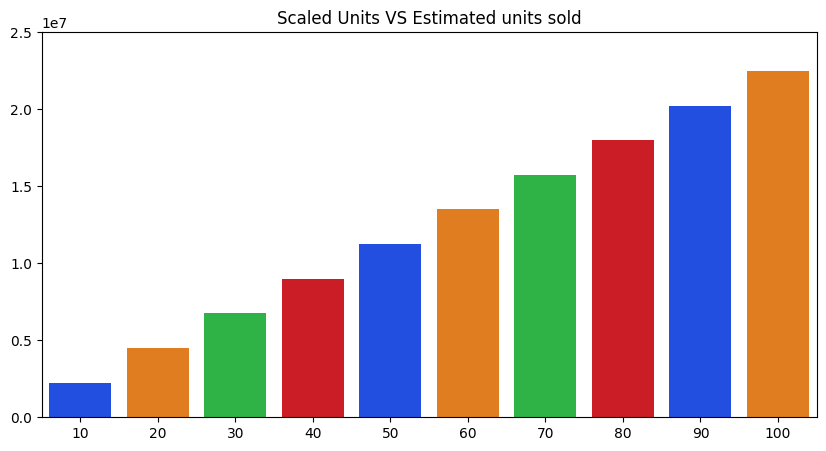

In [916]:
fig, ax = plt.subplots(figsize=(10, 5))
palette = sns.color_palette("bright", 4)
g = sns.barplot(clean_df, x=rate_value, y=scaled_units, palette= palette);
ax.set_title('Scaled Units VS Estimated units sold')
g.set(ylim = (0,25000000))
xlabels = ['{:,.2f}'.format(x) + 'K' for x in g.get_xticks()/1000]

We have a linear relationship between our scaling factor and number of units sold.

In [917]:
year_group = clean_df.groupby(clean_df.date.dt.year).mean()
year_group.head(4)

C:\Users\Heather\AppData\Local\Temp\ipykernel_12052\3377804675.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  year_group = clean_df.groupby(clean_df.date.dt.year).mean()


,price,all_review_total,user_review_total
date,,,
1984,9.99,484.0,11.0
1989,1.99,656.0,28.0
1990,14.99,767.0,13.0
1991,19.99,623.0,12.0


C:\Users\Heather\AppData\Local\Temp\ipykernel_12052\4120348472.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=year_group.index, rotation=30, ha='center')


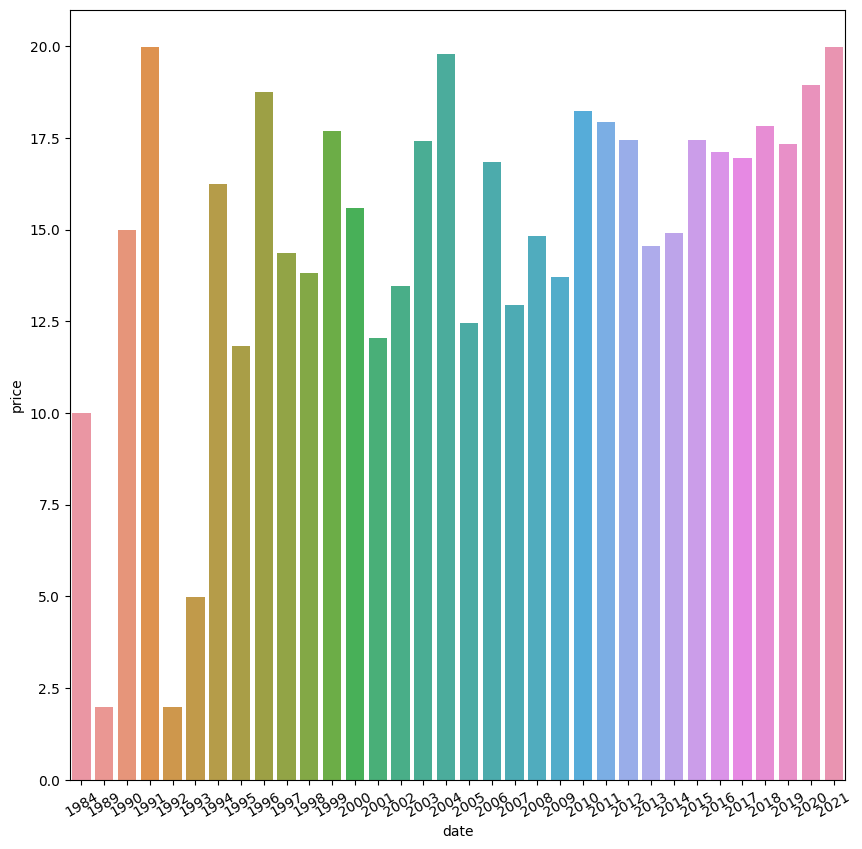

In [918]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_ylabel(ylabel='average price')
ax.set_xlabel(xlabel='year')
ax.set_xticklabels(labels=year_group.index, rotation=30, ha='center')
sns.barplot(x=year_group.index, y=year_group['price'], ax=ax);

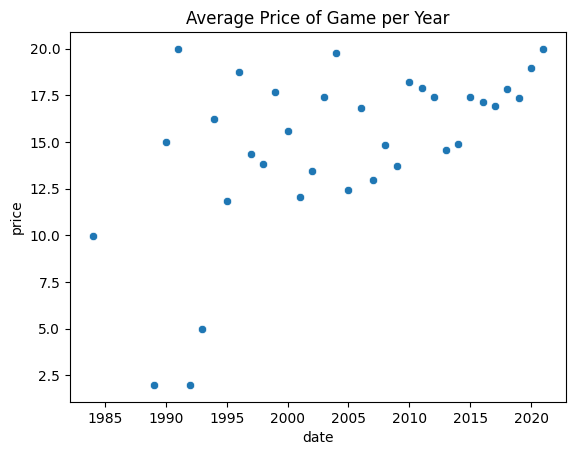

In [919]:
sns.scatterplot(x=year_group.index, y=year_group['price']).set(title='Average Price of Game per Year');

In [920]:
filter_corr = clean_df.select_dtypes(include=np.number)
filter_corr

,price,all_review_total,user_review_total
0,4.99,224878,151281
1,0.00,4843904,90780
2,19.99,223706,32436
3,49.99,18951,5359
5,24.99,41779,17940
...,...,...,...
39198,14.99,5642,14
40114,0.00,26,11
41944,0.99,21,12
42035,6.99,12,12


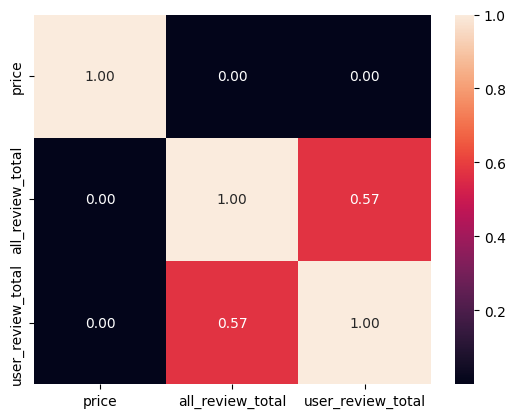

In [921]:
sns.heatmap(data=filter_corr.corr(), annot=True, fmt='.2f' );

### Model Pre-processing

In [922]:
clean_df.drop(['date', 'id', 'user_reviews', 'all_reviews'], inplace=True, axis=1)

In [923]:
categorical_df = clean_df[['full_desc', 'popu_tags', 'categories', 'developer', 'publisher', 'name']]
clean_df.drop(['full_desc', 'popu_tags', 'categories', 'developer', 'publisher', 'name'], inplace=True, axis=1)

In [924]:
clean_df.head(1)

,price,all_review_total,user_review_total,units
0,4.99,224878,151281,"{10: 2248780, 20: 4497560, 30: 6746340, 40: 89..."


convert dict to header/value pairs

In [925]:
units_df = pd.DataFrame.from_records(data=clean_df.units, columns=[index for index in range(10,110,10)])
clean_df = pd.concat([clean_df, units_df], axis=1)
clean_df.drop('units', inplace=True, axis=1)
clean_df.dropna(inplace=True)
print(clean_df.shape)
print(clean_df.dtypes)
clean_df.head(1)

(2054, 13)
price                float64
all_review_total     float64
user_review_total    float64
10                   float64
20                   float64
30                   float64
40                   float64
50                   float64
60                   float64
70                   float64
80                   float64
90                   float64
100                  float64
dtype: object


,price,all_review_total,user_review_total,10,20,30,40,50,60,70,80,90,100
0,4.99,224878.0,151281.0,2248780.0,4497560.0,6746340.0,8995120.0,11243900.0,13492680.0,15741460.0,17990240.0,20239020.0,22487800.0


In [926]:
y = clean_df[['price']]
y = np.ravel(y)
clean_df.drop('price', inplace=True, axis=1)

X = clean_df
X.columns = X.columns.astype(str)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=0)

print(x_train.head(2))
print(x_test.head(2))
print(y_train[:5])
print(y_test[:5])



      all_review_total  user_review_total       10       20       30       40  \
3129            1989.0               35.0  23500.0  47000.0  70500.0  94000.0   
1959            6569.0               82.0   4780.0   9560.0  14340.0  19120.0   

            50        60        70        80        90       100  
3129  117500.0  141000.0  164500.0  188000.0  211500.0  235000.0  
1959   23900.0   28680.0   33460.0   38240.0   43020.0   47800.0  
      all_review_total  user_review_total       10       20        30  \
1316            3695.0               51.0   1320.0   2640.0    3960.0   
3052             701.0               35.0  48190.0  96380.0  144570.0   

            40        50        60        70        80        90       100  
1316    5280.0    6600.0    7920.0    9240.0   10560.0   11880.0   13200.0  
3052  192760.0  240950.0  289140.0  337330.0  385520.0  433710.0  481900.0  
[ 3.99 14.99  4.99  0.   11.99]
[19.99  4.99 12.99 19.99  9.99]


### Model Selection

In [927]:
prettytable = PrettyTable(field_names=["Model", "Score"])

lr = LinearRegression()
lr_train = lr.fit(x_train, y_train)
lr_train_pred = lr_train.predict(x_train)
print(lr_train_pred[:5])

prettytable.add_row(['Linear Regression', round(lr_train.score(X=x_train, y=y_train), 5)])

[21.47190353 21.40418503 21.3984935  -4.89497879 21.46493027]


In [928]:
dt_r = DecisionTreeRegressor()
dt_r = dt_r.fit(x_train, y_train)
dtr_y_pred = dt_r.predict(x_train)
print(dtr_y_pred[:5])

prettytable.add_row(['Decision Tree Regressor', round(dt_r.score(x_train, y_train), 5)])

[ 3.99 14.99  4.99  0.   11.99]


In [929]:
rfr = RandomForestRegressor(n_estimators=50, random_state=0)
rfr = rfr.fit(x_train, y_train)
rfr_pred = rfr.predict(x_train)
print(rfr_pred[:5])

prettytable.add_row(['Random Forest Regressor', round(rfr.score(x_train, y_train), 5)])

[ 8.11   16.75    7.5302  4.0974 14.55  ]


In [930]:
b_ridge = linear_model.BayesianRidge()
b_ridge = b_ridge.fit(x_train, y_train)
bridge_pred = b_ridge.predict(x_train)
print(bridge_pred[:5])

prettytable.add_row(['Bayesian Ridge', round(b_ridge.score(x_train, y_train), 5)])

[21.4215502  21.36868117 21.36380903 10.43420153 21.41255506]


In [931]:
regr_svm = svm.SVR()
regr_svm.fit(x_train, y_train)
regr_svm_pred = regr_svm.predict(x_train)
print(regr_svm_pred[:5])

prettytable.add_row(['SVM Regressor', round(regr_svm.score(x_train, y_train), 5)])

[19.86600863 19.8251116  19.82456427 18.01839661 19.82439124]


In [932]:
prettytable

Model,Score
Linear Regression,0.00115
Decision Tree Regressor,1.0
Random Forest Regressor,0.84136
Bayesian Ridge,0.00196
SVM Regressor,-0.00355


In [933]:
# fig = plt.figure(figsize=(12, 9))

# gs = fig.add_gridspec(3, 4)
# ax0 = plt.subplot(gs[:2, :2])
# ax1 = plt.subplot(gs[2:, :2])
# ax2 = plt.subplot(gs[:3, 2:])

# sns.scatterplot(data=clean_df, x='date',
#                 y='clean_price',
#                 ax=ax0)

# sns.histplot(data=clean_df, x='user_review_total', bins=20,
#              ax=ax1)

# sns.boxplot(data=clean_df, x='date', y='clean_price', ax=ax2)

# ax2.set_xlabel('year')

# fig.suptitle('Steam Game Year and Price', fontsize=18)
# plt.tight_layout()

In [934]:
# from steam import Steam
# import requests
# import json


# file = open('./env.txt')
# STEAM_KEY = file.read() 
# data = []
# steam = Steam(STEAM_KEY)
# uuid='945360'

# def getgamereviews(uuid): 
#     result = requests.get('https://store.steampowered.com/appreviews/'+uuid+'?json=1cursor=20')
#     return result.text

# data.append(getgamereviews(uuid='945360'))
# with open('test.json', 'w', encoding="utf-8") as f:
#     json.dump(data, f)
# comments = []
# comments_dict = {}
# for row in data: 
#     json_line = json.loads(row)
#     for index in range(20):
#         comments.append(json_line['reviews'][index]['review'])
#     comments_dict[uuid] = comments
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# comments_df = pd.Series(comments_dict, name='comments')
# comments_df

We can confirm our accuracy through this third party website that tracks steam game unit sale estimations. https://steamdb.info/app/990080/charts/

The most important feature in predicting price and if the game will sell well is timing. Timing is everything. 
It's also dependent upon Early Access, DLC, and genre. 

Other metrics to look at in the future include computer requirements, total number of active players, follower count, and times when other similar games go on sale. 